This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# A quick start to zonal statistics 

Zonal statistics can be used to compute e.g. the areal average precipitation over a catchment.

Here, we show a brief example using RADOLAN composite data from the German Weather Service (DWD).

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
from osgeo import osr

## Preparing the RADOLAN data

Preparing the radar composite data includes to
- read the data,
- geoference the data in native RADOLAN projection,
- reproject the data to Germany Zone 2 projection.

In [2]:
# Read and preprocess the RADOLAN data
fpath = 'radolan/misc/raa01-sf_10000-1406100050-dwd---bin.gz'
f = wrl.util.get_wradlib_data_file(fpath)
data, attrs = wrl.io.read_radolan_composite(f, missing=np.nan)
sec = attrs['secondary']
data.flat[sec] = np.nan

In [3]:
# Get RADOLAN grid coordinates (lon/lat)
grid_xy_radolan = wrl.georef.get_radolan_grid(900, 900)
x_radolan = grid_xy_radolan[:, :, 0]
y_radolan = grid_xy_radolan[:, :, 1]

In [4]:
# This is the native RADOLAN projection
# (polar stereographic projection)
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# This is our target projection (Germany Zone 2)
proj_gk = osr.SpatialReference()
_ = proj_gk.ImportFromEPSG(31466)

In [5]:
# Reproject the RADOLAN coordinates
xy = wrl.georef.reproject(grid_xy_radolan,
                          projection_source=proj_stereo,
                          projection_target=proj_gk)

## Import catchment boundaries from ESRI shapefile

In [6]:
# Open shapefile (already in GK2)
shpfile = wrl.util.get_wradlib_data_file(
    'shapefiles/agger/agger_merge.shp')
dataset, inLayer = wrl.io.open_vector(shpfile)
cats, keys = wrl.georef.get_vector_coordinates(inLayer)
print("Found %d sub-catchments in shapefile." % len(cats))

Found 13 sub-catchments in shapefile.


## Clip subgrid from RADOLAN grid 

This is just to speed up the computation (so we don't have to deal with the full grid).

In [7]:
bbox = inLayer.GetExtent()
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
mask = (((xy[..., 1] > bbox['bottom']) & (xy[..., 1] < bbox['top'])) &
        ((xy[..., 0] > bbox['left']) & (xy[..., 0] < bbox['right'])))
xy_ = np.dstack((xy[..., 0][mask].ravel(), xy[..., 1][mask].ravel()))
data_ = data[mask]

## Compute the average precipitation for each catchment

To compute the zonal average, we have to understand the the grid cells as *polygons* defined by a set of *vertices*.

In [8]:
# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grdverts = wrl.zonalstats.grid_centers_to_vertices(x_radolan[mask],
                                                   y_radolan[mask], 
                                                   1., 1.)
# And reproject to our target projection (here: GK2)
grdverts = wrl.georef.reproject(grdverts,
                                projection_source=proj_stereo,
                                projection_target=proj_gk)

Based on the overlap of these polygons with the catchment area, we can then compute a *weighted average*. 

In [9]:
# This object collects our source and target data
#   and computes the intersections
zd = wrl.zonalstats.ZonalDataPoly(grdverts, cats, srs=proj_gk)

# This object can actually compute the statistics
obj = wrl.zonalstats.ZonalStatsPoly(zd)

# We just call this object with any set of radar data
avg = obj.mean(data_.ravel())

## Plot results in map

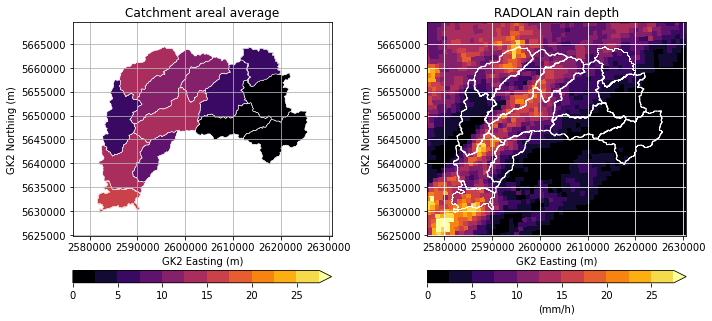

In [10]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches

# Create discrete colormap
levels=np.arange(0,30,2.5)
colors = pl.cm.inferno(np.linspace(0, 1, len(levels)))
mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

fig = pl.figure(figsize=(10, 10))

# Average rainfall sum
ax = fig.add_subplot(121, aspect="equal")
patches = [patches.Polygon(item, True) for item in obj.zdata.trg.data]
coll = PatchCollection(patches, array=avg, cmap=mycmap, norm=mynorm,
                       edgecolors='white', lw=0.5)
ax.add_collection(coll)
pl.colorbar(coll, ax=ax, orientation="horizontal", pad=0.05)
pl.xlabel("GK2 Easting (m)")
pl.ylabel("GK2 Northing (m)")
pl.title("Catchment areal average")
pl.xlim(bbox["left"], bbox["right"])
pl.ylim(bbox["bottom"], bbox["top"])
pl.grid()

# Original radar data
ax = fig.add_subplot(122, aspect="equal")
pm = pl.pcolormesh(xy[:, :, 0], xy[:, :, 1], 
                   np.ma.masked_invalid(data),
                   cmap=mycmap, norm=mynorm)
wrl.vis.add_patches(ax=ax, patch_array=cats, 
                    facecolor="None", edgecolor="white")
cb = pl.colorbar(pm, ax=ax, orientation="horizontal", pad=0.05)
cb.set_label("(mm/h)")
pl.xlabel("GK2 Easting (m)")
pl.ylabel("GK2 Northing (m)")
pl.title("RADOLAN rain depth")
pl.xlim(bbox["left"], bbox["right"])
pl.ylim(bbox["bottom"], bbox["top"])
pl.grid(color="white")
pl.tight_layout()

## Save time by reading the weights from a file

The computational expensive part is the computation of intersections and weights. You only need to do it *once*.

You can dump the results on disk and read them from there when required. Let's do a little benchmark:

In [11]:
import datetime as dt

# dump to file
zd.dump_vector('test_zonal_poly_cart')

t1 = dt.datetime.now()
# Create instance of type ZonalStatsPoly from zonal data file
obj = wrl.zonalstats.ZonalStatsPoly('test_zonal_poly_cart')
t2 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from sratch
zd = wrl.zonalstats.ZonalDataPoly(grdverts, cats, srs=proj_gk)
obj = wrl.zonalstats.ZonalStatsPoly(zd)
t3 = dt.datetime.now()

# Calling the object
avg = obj.mean(data_.ravel())
t4 = dt.datetime.now()

print("\nCreate object from file: %f seconds" % (t2 - t1).total_seconds())
print("Create object from sratch: %f seconds" % (t3 - t2).total_seconds())
print("Compute stats: %f seconds" % (t4 - t3).total_seconds())


Create object from file: 0.568113 seconds
Create object from sratch: 3.844200 seconds
Compute stats: 0.001497 seconds
